# Titanic — EDA passo a passo
**Objetivo**: mostrar um fluxo típico de *Exploratory Data Analysis* (EDA) no clássico conjunto de dados do Titanic (Kaggle).  
O foco aqui é **entender os dados**, não treinar o melhor modelo.

> **Como usar**: coloque `train.csv` (e opcionalmente `test.csv`) na mesma pasta deste notebook ou ajuste as variáveis de caminho na próxima célula.

In [4]:
# Imports e configurações básicas
import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# Para gráficos em notebooks
# (no Jupyter Lab/Notebook não precisa do inline explicitamente, mas não faz mal)
%matplotlib inline


## 1) Carregar dados
Tente carregar `train.csv` e `test.csv`.  
Se não tiver o `test.csv`, o notebook continua só com o `train.csv`.

In [5]:
# Ajuste os caminhos se necessário
PATH_TRAIN = "train.csv"      # ex.: "../input/titanic/train.csv"
PATH_TEST  = "test.csv"       # ex.: "../input/titanic/test.csv"

# Carregamento com mensagens amigáveis
if not os.path.exists(PATH_TRAIN):
    raise FileNotFoundError(f"Não encontrei {PATH_TRAIN}. Coloque o arquivo ao lado do notebook ou ajuste PATH_TRAIN.")

train = pd.read_csv(PATH_TRAIN)
test  = pd.read_csv(PATH_TEST) if os.path.exists(PATH_TEST) else None

train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2) Dicionário de dados (informal)
Referência rápida das colunas mais usadas:

- **Survived**: alvo (0 = não sobreviveu, 1 = sobreviveu)
- **Pclass**: classe do ticket (1, 2, 3) — *proxy* de status socioeconômico
- **Sex**: sexo
- **Age**: idade
- **SibSp**: # de irmãos/cônjuges a bordo
- **Parch**: # de pais/filhos a bordo
- **Fare**: tarifa paga
- **Embarked**: porto de embarque (C/Q/S)
- **Ticket**, **Cabin**, **Name**: texto livre com possíveis *features* deriváveis

## 3) Olhada geral: tipos, dimensão, amostras

In [6]:
print("Shape do train:", train.shape)
display(train.head(10))
print("\nTipos de dados:")
display(train.dtypes)


Shape do train: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C



Tipos de dados:


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## 4) Alvo e balanceamento
Distribuição de `Survived`.

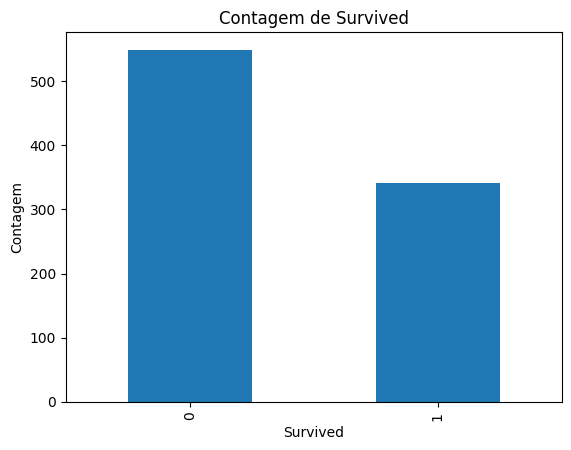

Survived
0    0.616
1    0.384
Name: proporção, dtype: float64


In [7]:
# Checar se a coluna Survived existe (deve existir no train)
assert "Survived" in train.columns, "Coluna Survived não encontrada no train.csv."

ax = train["Survived"].value_counts().sort_index().plot(kind="bar")
ax.set_title("Contagem de Survived")
ax.set_xlabel("Survived")
ax.set_ylabel("Contagem")
plt.show()

print(train["Survived"].value_counts(normalize=True).rename("proporção").round(3))


## 5) Valores faltantes (missing values)
Quais colunas têm nulos? Qual a porcentagem?

,percentual_%
Cabin,77.1
Age,19.9
Embarked,0.2
PassengerId,0.0
Survived,0.0
Pclass,0.0
Name,0.0
Sex,0.0
SibSp,0.0
Parch,0.0


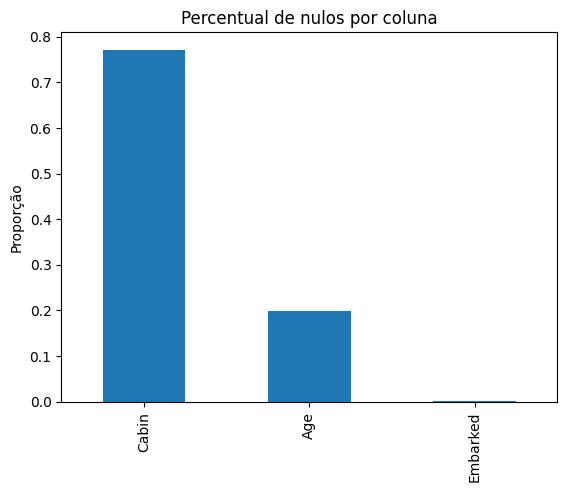

In [8]:
missing = train.isna().mean().sort_values(ascending=False)
display((missing*100).round(1).rename("percentual_%").to_frame())
ax = (missing[missing>0]).plot(kind="bar")
ax.set_title("Percentual de nulos por coluna")
ax.set_ylabel("Proporção")
plt.show()


## 6) Distribuições básicas (numéricas)
Olhe rapidamente histograma de algumas numéricas (`Age`, `Fare`, `SibSp`, `Parch`).

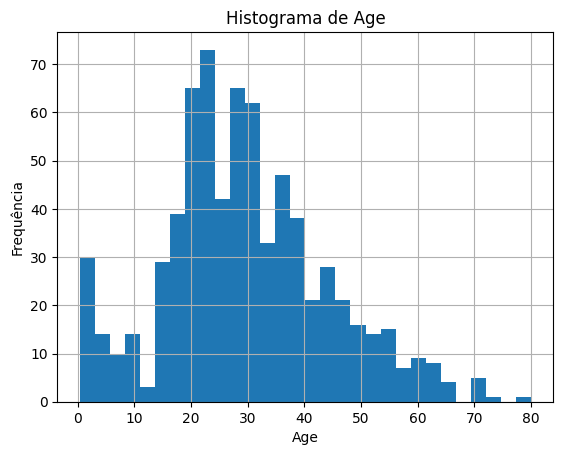

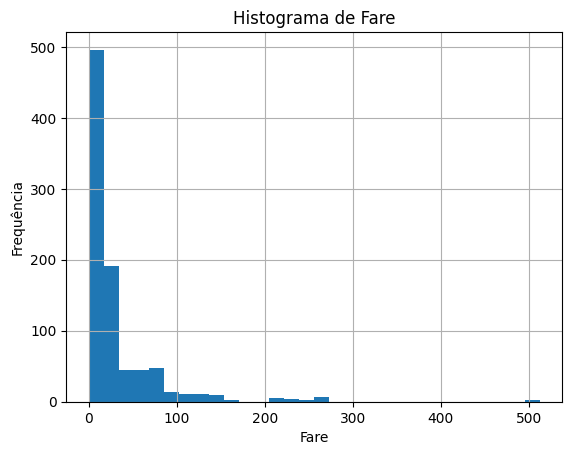

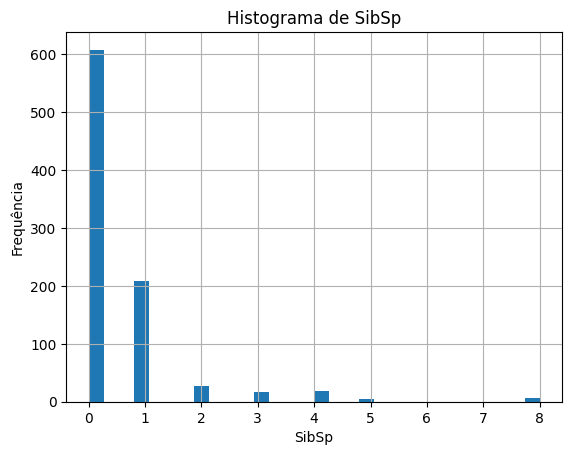

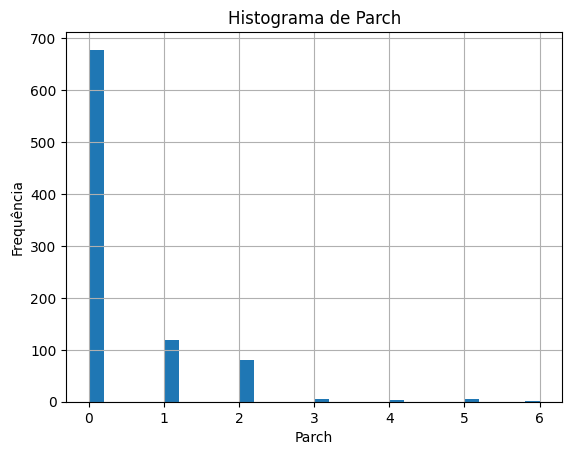

In [9]:
num_cols = [c for c in ["Age","Fare","SibSp","Parch"] if c in train.columns]
for c in num_cols:
    train[c].hist(bins=30)
    plt.title(f"Histograma de {c}")
    plt.xlabel(c); plt.ylabel("Frequência")
    plt.show()


## 7) Distribuições (categóricas)
Contagens para `Sex`, `Pclass`, `Embarked` (se existirem).

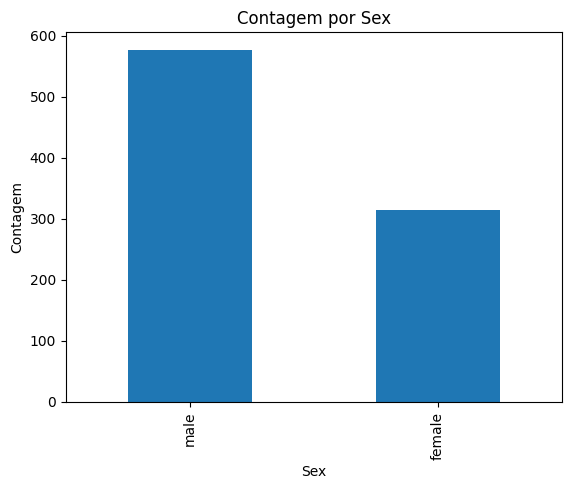

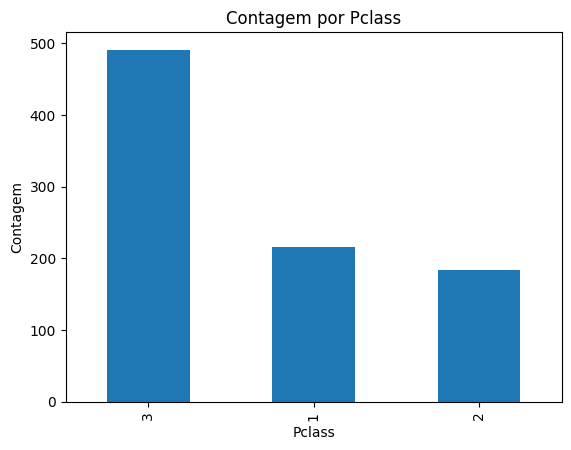

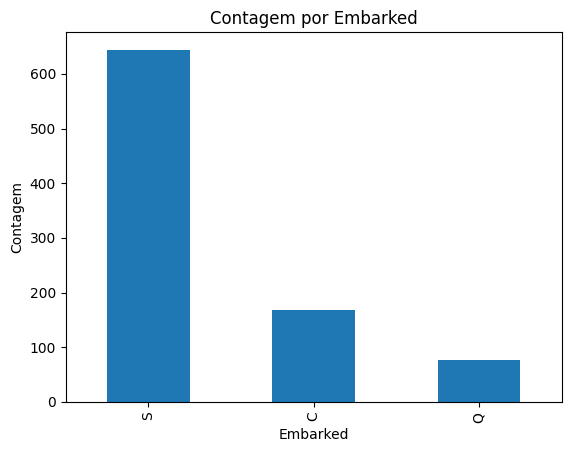

In [10]:
cat_cols = [c for c in ["Sex","Pclass","Embarked"] if c in train.columns]
for c in cat_cols:
    train[c].value_counts().plot(kind="bar")
    plt.title(f"Contagem por {c}")
    plt.xlabel(c); plt.ylabel("Contagem")
    plt.show()


## 8) *Feature engineering* mínima para EDA
Criamos algumas colunas úteis **apenas para análise** (não é modelagem ainda):
- `FamilySize = SibSp + Parch + 1`
- `IsAlone = 1 se FamilySize == 1, senão 0`
- `Deck` a partir de `Cabin` (primeira letra)
- `Title` extraído de `Name`

In [11]:
df = train.copy()

# FamilySize / IsAlone
df["FamilySize"] = df["SibSp"].fillna(0) + df["Parch"].fillna(0) + 1
df["IsAlone"]    = (df["FamilySize"]==1).astype(int)

# Deck a partir de Cabin (primeira letra, quando existir)
def first_letter(s):
    if isinstance(s, str) and len(s.strip())>0:
        return s.strip()[0]
    return np.nan

if "Cabin" in df.columns:
    df["Deck"] = df["Cabin"].map(first_letter)

# Title a partir do Name
if "Name" in df.columns:
    df["Title"] = df["Name"].str.extract(r",\s*([^\.]+)\.", expand=False).str.strip()
    map_titles = {
        "Mlle":"Miss","Ms":"Miss","Mme":"Mrs","Lady":"Royalty","Countess":"Royalty",
        "Sir":"Royalty","Don":"Royalty","Dona":"Royalty","Jonkheer":"Royalty",
        "Capt":"Officer","Col":"Officer","Major":"Officer","Dr":"Officer","Rev":"Officer"
    }
    df["Title"] = df["Title"].replace(map_titles)

df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Deck,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,NaN,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,NaN,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0,C,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1,NaN,Mr


## 9) Sobrevivência por categorias
Taxa média de `Survived` por `Sex`, `Pclass`, `Embarked`, `Title`, `Deck`, `IsAlone`, etc.

,taxa_survived
Sex,
female,0.742
male,0.189


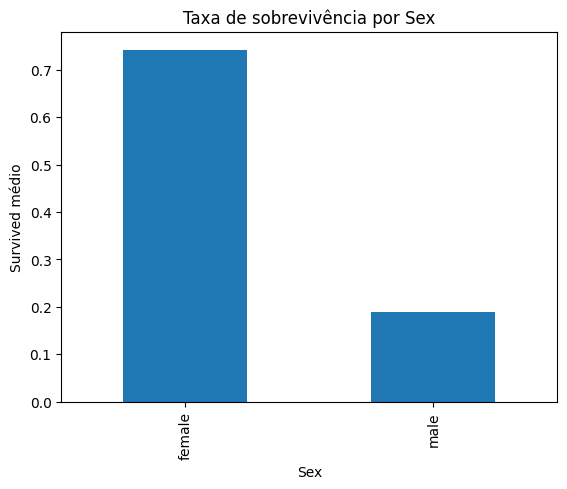

,taxa_survived
Pclass,
1,0.630
2,0.473
3,0.242


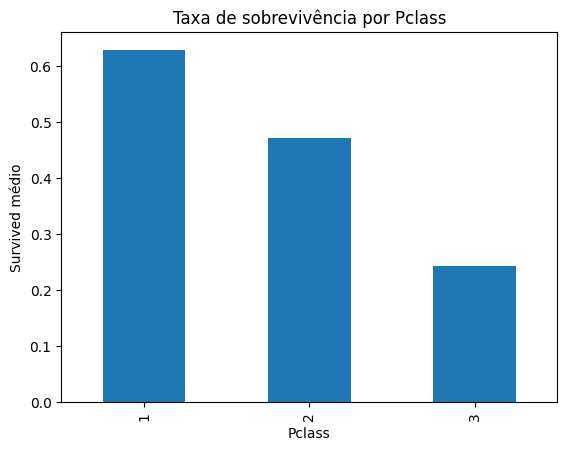

,taxa_survived
Embarked,
C,0.554
Q,0.390
S,0.337


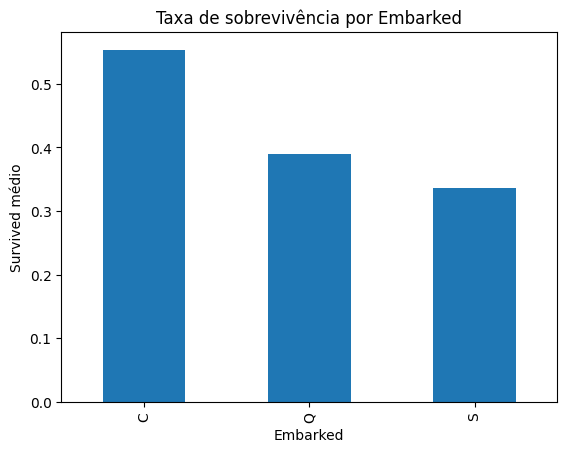

,taxa_survived
Title,
the Countess,1.000
Mrs,0.794
Miss,0.703
Master,0.575
Royalty,0.500
Officer,0.278
Mr,0.157


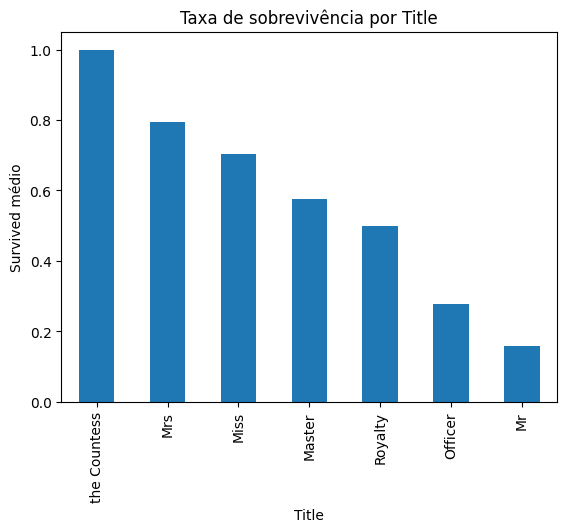

,taxa_survived
Deck,
D,0.758
E,0.750
B,0.745
F,0.615
C,0.593
G,0.500
A,0.467
T,0.000


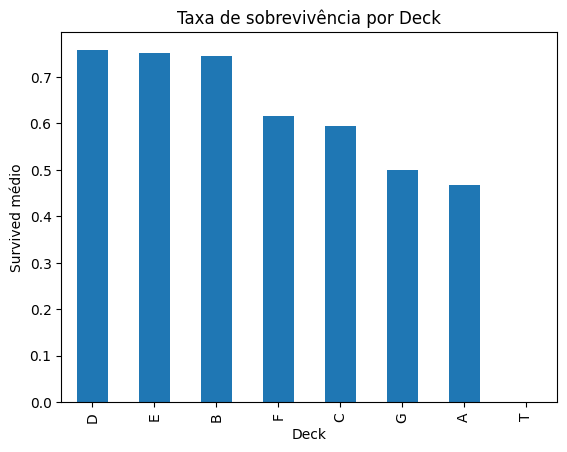

,taxa_survived
IsAlone,
0,0.506
1,0.304


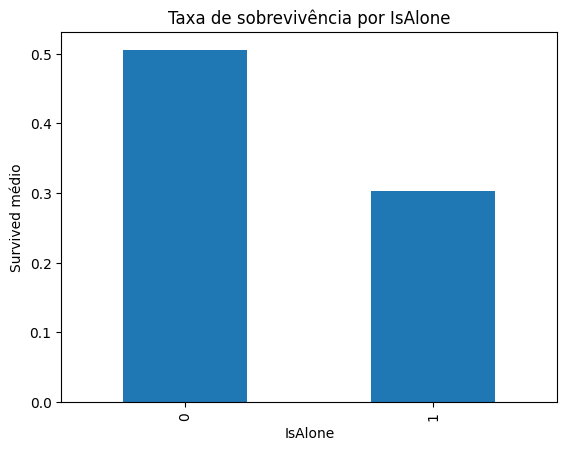

In [12]:
group_cols = [c for c in ["Sex","Pclass","Embarked","Title","Deck","IsAlone"] if c in df.columns]
for c in group_cols:
    rate = df.groupby(c)["Survived"].mean().sort_values(ascending=False)
    display(rate.to_frame(name="taxa_survived").round(3))
    rate.plot(kind="bar")
    plt.title(f"Taxa de sobrevivência por {c}")
    plt.ylabel("Survived médio")
    plt.show()


## 10) Faixas de idade e tarifa
Criamos *bins* simples para `Age` e `Fare` e vemos a taxa de sobrevivência.

/tmp/ipykernel_114320/2815814927.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.groupby(c)["Survived"].mean()


,taxa_survived
AgeBin,
"(-0.001, 12.0]",0.580
"(12.0, 18.0]",0.429
"(18.0, 40.0]",0.388
"(40.0, 60.0]",0.391
"(60.0, 120.0]",0.227


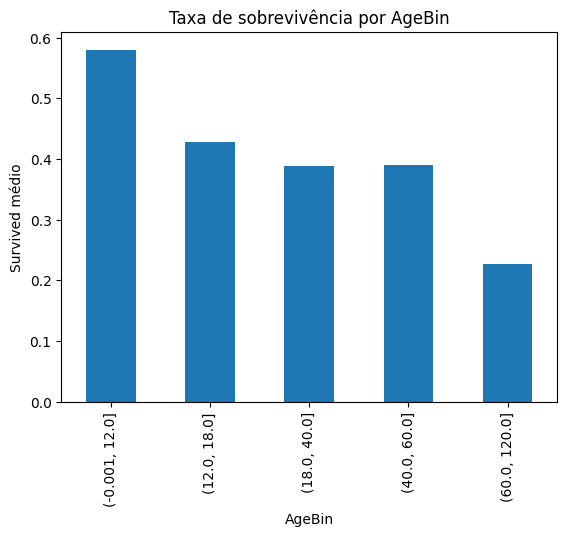

/tmp/ipykernel_114320/2815814927.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.groupby(c)["Survived"].mean()


,taxa_survived
FareBin,
"(-0.001, 7.854]",0.218
"(7.854, 10.5]",0.201
"(10.5, 21.679]",0.424
"(21.679, 39.688]",0.444
"(39.688, 512.329]",0.642


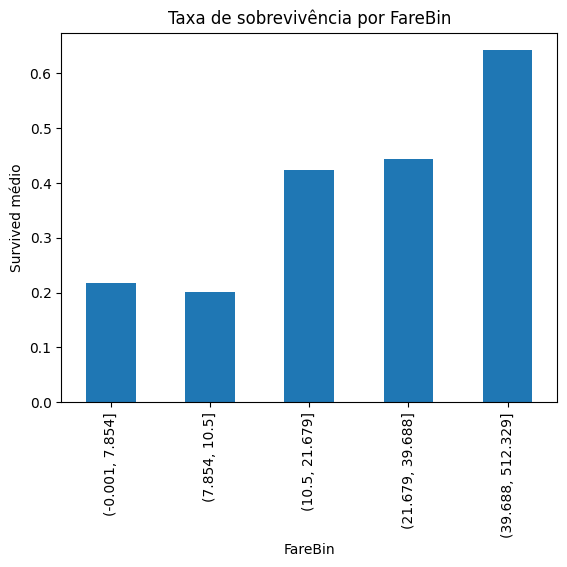

In [13]:
df["AgeBin"]  = pd.cut(df["Age"], bins=[0,12,18,40,60,120], include_lowest=True)
df["FareBin"] = pd.qcut(df["Fare"], q=5, duplicates="drop")  # quantis

for c in ["AgeBin","FareBin"]:
    if c in df.columns:
        rate = df.groupby(c)["Survived"].mean()
        display(rate.to_frame(name="taxa_survived").round(3))
        rate.plot(kind="bar")
        plt.title(f"Taxa de sobrevivência por {c}")
        plt.ylabel("Survived médio")
        plt.show()


## 11) Correlação (numéricas)
Correlação de Pearson entre variáveis numéricas simples.

,Age,Fare,SibSp,Parch,FamilySize,IsAlone
Age,1.00,0.10,-0.31,-0.19,-0.30,0.20
Fare,0.10,1.00,0.16,0.22,0.22,-0.27
SibSp,-0.31,0.16,1.00,0.41,0.89,-0.58
Parch,-0.19,0.22,0.41,1.00,0.78,-0.58
FamilySize,-0.30,0.22,0.89,0.78,1.00,-0.69
IsAlone,0.20,-0.27,-0.58,-0.58,-0.69,1.00


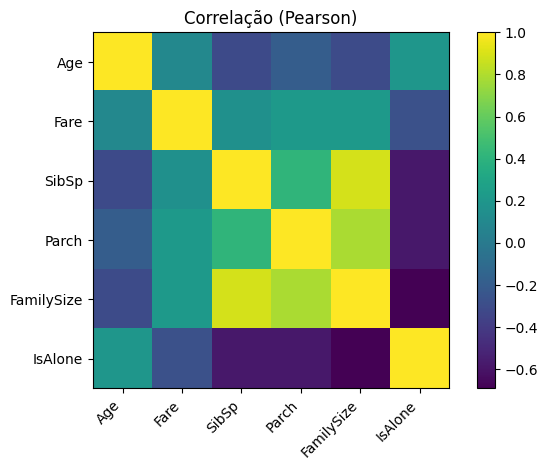

In [14]:
num_for_corr = [c for c in ["Age","Fare","SibSp","Parch","FamilySize","IsAlone"] if c in df.columns]
corr = df[num_for_corr].corr(method="pearson")
display(corr.round(2))

# Heatmap simples com matplotlib (sem seaborn)
fig, ax = plt.subplots()
cax = ax.imshow(corr.values, interpolation="nearest")
ax.set_xticks(range(len(num_for_corr))); ax.set_xticklabels(num_for_corr, rotation=45, ha="right")
ax.set_yticks(range(len(num_for_corr))); ax.set_yticklabels(num_for_corr)
ax.set_title("Correlação (Pearson)")
fig.colorbar(cax)
plt.tight_layout()
plt.show()


## 12) Outliers rápidos (ex.: Fare)
Olhar boxplot simples.

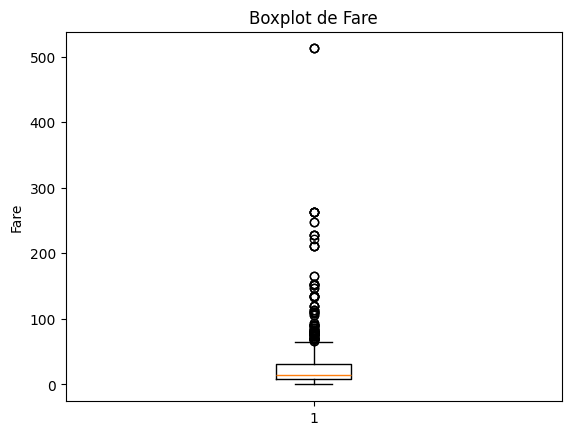

In [15]:
if "Fare" in df.columns:
    plt.boxplot(df["Fare"].dropna().values, vert=True)
    plt.title("Boxplot de Fare")
    plt.ylabel("Fare")
    plt.show()


## 13) Possível vazamento / grupos
Um check simples de quantos passageiros compartilham `Ticket` (potencialmente famílias ou grupos).

In [16]:
if "Ticket" in df.columns:
    counts = df["Ticket"].value_counts()
    print("Tickets com mais de 1 passageiro:", (counts>1).sum())
    print("Top 10 tickets (contagem):")
    display(counts.head(10).to_frame("contagem"))


Tickets com mais de 1 passageiro: 134
Top 10 tickets (contagem):


,contagem
Ticket,
347082,7
CA. 2343,7
1601,7
3101295,6
CA 2144,6
347088,6
S.O.C. 14879,5
382652,5
LINE,4


## 14) Drift entre train e test (opcional)
Se `test.csv` estiver disponível, compare algumas distribuições.

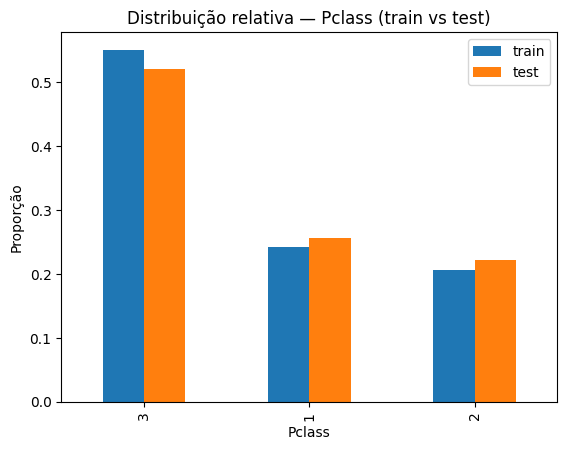

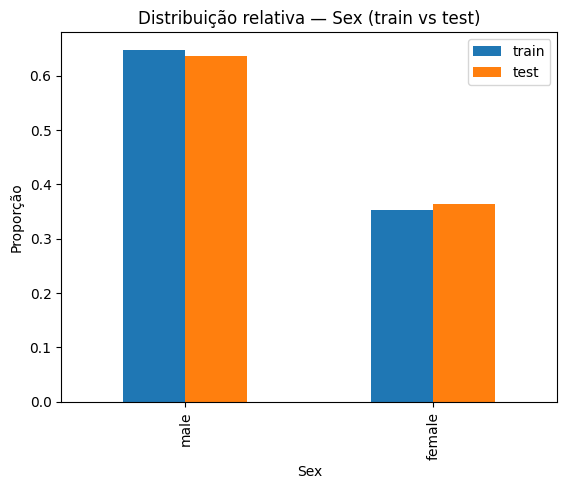

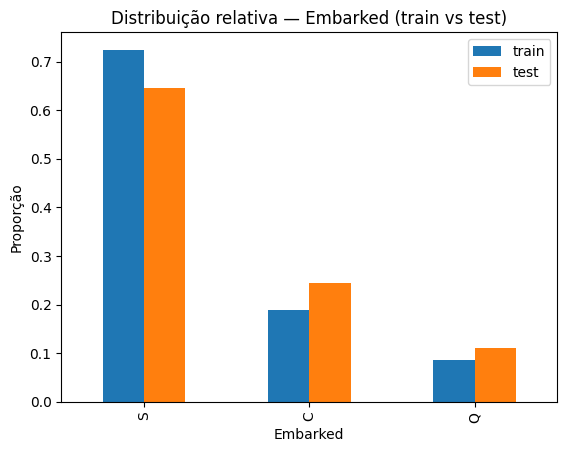

In [17]:
if test is not None:
    cols_check = [c for c in ["Pclass","Sex","Embarked"] if c in train.columns and c in test.columns]
    for c in cols_check:
        fig, ax = plt.subplots()
        pd.DataFrame({
            "train": train[c].value_counts(normalize=True),
            "test":  test[c].value_counts(normalize=True)
        }).plot(kind="bar", ax=ax)
        ax.set_title(f"Distribuição relativa — {c} (train vs test)")
        ax.set_ylabel("Proporção")
        plt.show()
else:
    print("Arquivo test.csv não encontrado — pulando comparação train vs test.")


## 15) Conclusões (anote aqui)
- `Sex` e `Pclass` mostram forte relação com `Survived`.
- `Age` e `Fare` também têm padrões (ex.: crianças tendem a sobreviver mais).
- Tamanho da família (`FamilySize`) e `IsAlone` adicionam contexto social.
- Títulos (`Title`) extraídos de `Name` e `Deck` de `Cabin` podem ser úteis.
- Há *missing values* em colunas como `Age` e `Cabin` que requerem tratamento no pipeline de modelagem.

> Próximos passos (fora do EDA): imputação, *feature engineering* final, codificação (OHE/TE-OOF), validação adequada (Stratified/GroupKFold), modelagem e *thresholding*.